# RAG Experiments - Goodreads Dataset

We start by defining a few constants and imports

In [1]:
DATASET_DIR = "../../datasets/books/"

In [2]:
import os

DB_PATH = os.path.join(DATASET_DIR, "vector_db")
EVAL_PATH = os.path.join(DATASET_DIR, "eval.csv")

In [3]:
from langchain.chains import LLMChain, RetrievalQA, HypotheticalDocumentEmbedder
from langchain.prompts import PromptTemplate
from langchain_openai import OpenAIEmbeddings, OpenAI, ChatOpenAI
from langchain_chroma import Chroma

In [4]:
import getpass
import os

os.environ["OPENAI_API_KEY"] = os.environ.get("OPENAI_API_KEY", getpass.getpass())

 ········


---

## Retrieval

### Naive

Standard retriever from Vector Store

In [5]:
embeddings = OpenAIEmbeddings(model="text-embedding-3-small")

In [6]:
naive_retriever = Chroma(persist_directory=DB_PATH, embedding_function=embeddings).as_retriever()

### Hyde (Hypothetical Document Embeddings)

HyDE retriever from Vector Store

In [7]:
base_embeddings = OpenAIEmbeddings(model="text-embedding-3-small")

In [8]:
prompt_template = "Please answer the question \nQuestion: {question}\nAnswer:"
prompt = PromptTemplate(input_variables=["question"], template=prompt_template)

generative_model = OpenAI(model="gpt-3.5-turbo-instruct")

retriever_chain = LLMChain(llm=generative_model, prompt=prompt)

/Users/knethil/projects/dense-rags/.venv/lib/python3.10/site-packages/langchain_core/_api/deprecation.py:139: LangChainDeprecationWarning: The class `LLMChain` was deprecated in LangChain 0.1.17 and will be removed in 1.0. Use RunnableSequence, e.g., `prompt | llm` instead.
  warn_deprecated(


In [9]:
embeddings = HypotheticalDocumentEmbedder(
    llm_chain=retriever_chain, base_embeddings=base_embeddings
)

In [10]:
hyde_retriever = Chroma(persist_directory=DB_PATH, embedding_function=embeddings).as_retriever()

---

## Generation

Retriever uses Query to get Context Documents from the Vector Store. Both Query and Context are used to prompt a generative model for the Answer.

Notice, the better retrieval with HyDE - more relevant documents are seemingly retrieved. (But this is a sample size of 1!)

In [11]:
from langchain_core.runnables import RunnablePassthrough
from langchain_core.output_parsers import StrOutputParser

In [12]:
prompt_template = '''You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.
Question: {question} 
Context: {context} 
Answer:'''

prompt = PromptTemplate(input_variables=["question", "context"], template=prompt_template)

llm = ChatOpenAI(model="gpt-3.5-turbo", temperature=0.7)

In [13]:
def get_chain(retriever, llm, prompt):
    qa_chain = RetrievalQA.from_chain_type(
        llm,
        retriever=retriever,
        chain_type_kwargs={"prompt": prompt},
        return_source_documents=True,
    )
    return qa_chain

### Naive output

In [14]:
# Cost/compute intensive

question = "What is a good book for adults with depression?"
naive_rag = get_chain(naive_retriever, llm, prompt)
result = naive_rag.invoke({"query": question})
result["result"]

'"The Mindful Way through Depression: Freeing Yourself from Chronic Unhappiness" is a good book for adults with depression. It draws on cognitive therapy and mindfulness to help break mental habits that lead to despair, with methods proven to reduce chronic unhappiness. The book includes informative chapters, guided meditations on CD, and offers ways to strengthen resilience and regain a sense of balance and contentment.'

### HyDE output

In [15]:
# Cost/compute intensive

question = "What is a good book for adults with depression?"
hyde_rag = get_chain(hyde_retriever, llm, prompt)
result = hyde_rag.invoke({"query": question})
result["result"]

'A good book for adults with depression is "The Mindful Way through Depression: Freeing Yourself from Chronic Unhappiness." It draws on the wisdom of cognitive therapy and mindfulness experts to help break mental habits that lead to despair. The self-help program is clinically proven to reduce chronic unhappiness and strengthen resilience.'

---

## Evaluation

Ragas evaluators are used to measure performance of Retrievers on a synthetic dataset

### Metrics

In [16]:
import nest_asyncio
from ragas.integrations.langchain import EvaluatorChain
from ragas.metrics import (
    faithfulness,
    answer_relevancy,
    context_precision,
    context_recall,
)

# create eval chains
eval_chains = {
    m.name: EvaluatorChain(metric=m) 
    for m in [faithfulness, answer_relevancy, context_precision, context_recall]
}

In [31]:
# evaluate
def evaluate(sample):
    metrics = {}
    for name, eval_chain in eval_chains.items():
        score_name = f"{name}"
        metrics[score_name] = eval_chain(sample)[name]
        # print(f"{score_name}: {metrics[score_name]}")
    return metrics

In [18]:
#collect metrics

from tqdm.auto import tqdm

nest_asyncio.apply()

def get_metrics(results): 
    metrics = []
    for res in tqdm(results):
        sample= {
            "question": res["query"],
            "answer": res["result"],
            "contexts": [context.page_content for context in res["source_documents"]],
            "ground_truth": res["ground_truth"],
        }
        metrics.append(evaluate(sample))
    return metrics

### Dataset

In [19]:
EVAL_SIZE = 50

In [20]:
import pandas as pd

eval_df = pd.read_csv(EVAL_PATH)
eval_df.head()

,context,question,answer,source_doc
0,Book: Jami' At-Tirmidhi\nDescription:,What is the name of the book described?\n,Jami' At-Tirmidhi,../datasets/books/data.csv
1,Book: Permanent Record\nDescription: Edward Sn...,"Who is the author of the book ""Permanent Recor...",Edward Snowden,../datasets/books/data.csv
2,Book: A Walk Toward Jesus: Coming Through the ...,"Who is the author of the book ""A Walk Toward J...",Pamela S. Valerio,../datasets/books/data.csv
3,Description: The Works of Edgar Allen Poe incl...,What famous authors' works are included alongs...,"Mark Twain, Robert Louis Stevenson, Charles Di...",../datasets/books/data.csv
4,Description: **** 5 out of 5 Star Rating from ...,"Who is the author of the book ""The Weapon of M...",Ambrose V. Bruno,../datasets/books/data.csv


In [21]:
eval_questions = eval_df["question"].to_list()
eval_answers = eval_df["answer"].to_list()

examples = [
    {"query": q, "ground_truth": eval_answers[i]}
    for i, q in enumerate(eval_questions)
]

In [22]:
import random

examples = random.sample(examples, EVAL_SIZE)

### Naive RAG

In [23]:
# Cost/compute intensive

results = naive_rag.batch(examples)

In [24]:
# Cost/compute intensive

metrics = get_metrics(results)

  0%|          | 0/50 [00:00<?, ?it/s]

/Users/knethil/projects/dense-rags/.venv/lib/python3.10/site-packages/langchain_core/_api/deprecation.py:139: LangChainDeprecationWarning: The method `Chain.__call__` was deprecated in langchain 0.1.0 and will be removed in 0.3.0. Use invoke instead.
  warn_deprecated(
No statements were generated from the answer.
No statements were generated from the answer.
No statements were generated from the answer.


In [25]:
naive_metrics_df = pd.DataFrame(metrics)
naive_metrics_df.mean()

faithfulness_score         0.826039
answer_relevancy_score     0.895427
context_precision_score    0.820000
context_recall_score       0.860000
dtype: float64

### HyDE RAG

In [26]:
# Cost/compute intensive

results = hyde_rag.batch(examples)

In [27]:
# Cost/compute intensive

metrics = get_metrics(results)

  0%|          | 0/50 [00:00<?, ?it/s]

No statements were generated from the answer.
No statements were generated from the answer.


In [28]:
hyde_metrics_df = pd.DataFrame(metrics)
hyde_metrics_df.mean()

faithfulness_score         0.709623
answer_relevancy_score     0.868203
context_precision_score    0.660000
context_recall_score       0.680000
dtype: float64

---

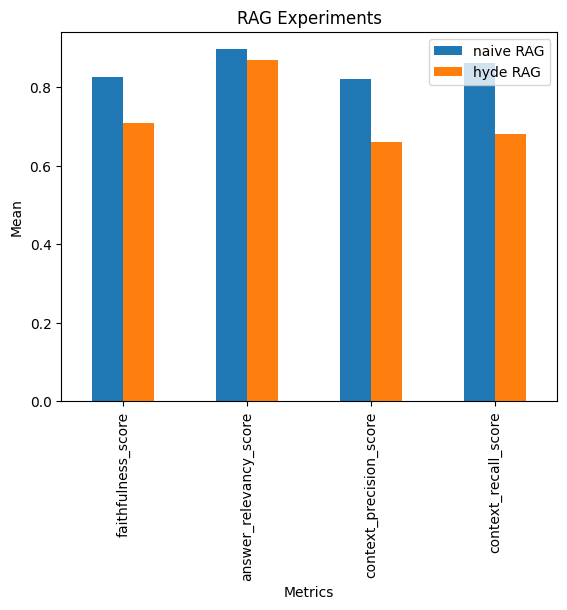

In [30]:
import pandas as pd
import matplotlib.pyplot as plt

combined_metrics = pd.DataFrame(
    {
        "naive RAG": naive_metrics_df.mean(),
        "hyde RAG": hyde_metrics_df.mean(),        
    }
)

# plot combined metrics
combined_metrics.plot(kind='bar')
plt.title('RAG Experiments')
plt.ylabel('Mean')
plt.xlabel('Metrics')
plt.show()